### Test of data instantiation

In [1]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader 
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import os
from torchmetrics import FBetaScore, Accuracy
from torchvision.utils import draw_bounding_boxes

import torchvision.transforms as T
from torchvision.transforms import functional as F

import pandas as pd
from src import BWDatasets
from paddleocr import PaddleOCR
import paddle


c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


### Ensure Reproducibility

In [2]:
seed = 115
generator = torch.Generator()
generator.manual_seed(seed)
np_generator = np.random.default_rng(seed=seed)

### Activate CUDA

In [3]:
device = torch.device('cpu')

# Make sure the notebook is deterministic if training on gpu
if torch.cuda.is_available():
    device = torch.device('cuda')
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False

print(f'Cuda availability is: {torch.cuda.is_available()}')  # Returns True if a GPU is available
print(f"Training on device {device}.")

Cuda availability is: True
Training on device cuda.


In [ ]:
# Lyngøy
label_path = "dataset/datasets/lyngoy/ringcodes.csv"
image_path = "dataset/datasets/lyngoy/images"
bb_path = "dataset/datasets/lyngoy/labels"

# RF
# label_path = "dataset/datasets/rf/ringcodes.csv"
# image_path = "dataset/datasets/rf/images"
# bb_path = "dataset/datasets/rf/labels"

# ringmerkinno
# label_path = "dataset/datasets/ringmerkingno/ringcodes.csv"
# image_path = "dataset/datasets/ringmerkingno/images"
# bb_path = "dataset/datasets/ringmerkingno/labels"

max_n = 100
transform = T.Compose([
    # T.Resize((64,32)),
    T.Resize((224,112)),
    T.Lambda(lambda x: F.rotate(x, 270, expand=True))
])
exp_dataset = BWDatasets.TrainDataSet(img_path=image_path, labels_path=label_path, bb_path=bb_path, transform=transform, max_n=None)


In [5]:
def draw_image(img):
    img_uint8 = (img * 255).to(dtype=torch.uint8)
    img_uint8 = img_uint8.permute(1, 2, 0)
    plt.figure(figsize=(12,12))
    plt.imshow(img_uint8)
    plt.axis("off")
    plt.show()

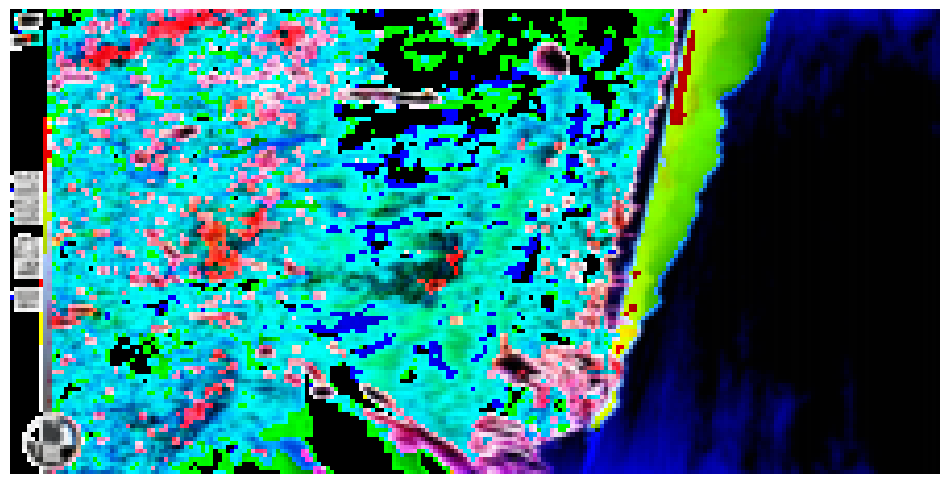

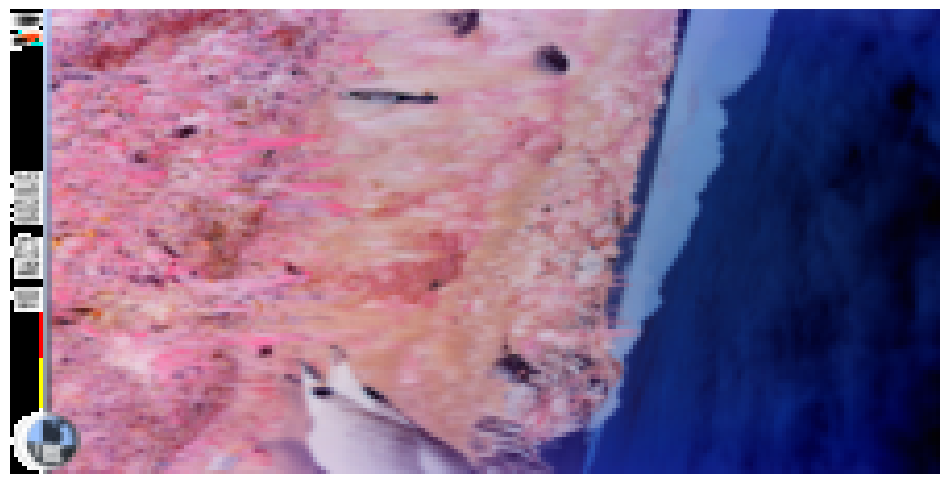

In [ ]:
data = exp_dataset[1]

draw_image(data["ocr_image"])
draw_image(data["image"])

In [7]:
#stop



In [8]:
paddle.device.set_device("gpu:0")
ocr = PaddleOCR(lang="en", 
        #    text_detection_model_dir="src/models/paddleOCR/det", 
        #    text_recognition_model_dir="src/models/paddleOCR/rec", 
        #    textline_orientation_model_dir="src/models/paddleOCR/cls", 
           use_doc_orientation_classify=True, 
           use_doc_unwarping=True, 
           use_textline_orientation=True, device='gpu')


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 5263.72it/s]
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 5803.93it/s]
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 11715.93it/s]
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 

In [10]:

exp_loader = DataLoader(dataset=exp_dataset, batch_size=64, shuffle=True, generator=generator)


In [ ]:
def prediction(dataloader):
    preds = []
    targets = []
    count = 0
    for data in dataloader:
        count +=1
        print(f'Batch {count} of {len(dataloader)}')
        images = BWDatasets.tensor_to_numpy(data["ocr_image"])
        labels = data["label"][0]
        for i, image in enumerate(images):
            
            result = ocr.predict(image)

            pred = result[0]["rec_texts"]

            if not pred:
                pred = ['Not Found']

            preds.append(pred[0])

            label = labels[i]
            
            targets.append(label)

            # print("-------------------")
            # print(f'Prediction: {pred}')
            # print(f'Actual: {label}')

            # plt.figure(figsize=(4,2))
            # plt.imshow(image, cmap="gray")
            # plt.axis("off")
            # plt.show()
    return preds, targets


In [12]:
def evaluate_model(preds, labels):
    print(f'preds: {preds}')
    print(f'labels: {labels}')
    
    # Boolean mask for the predictions and the labels
    # Prediction = 1 if it is correct, 0 otherwise
    # Labels are always = to 1
    bin_preds = [int(pred == label) for pred, label in zip(preds, labels)]
    bin_labels = [1]*len(labels)

    preds_tensor, labels_tensor = torch.tensor(bin_preds), torch.tensor(bin_labels)
    fbeta = FBetaScore(task='binary', beta=0.5)
    acc = Accuracy(task='binary')

    print(f'Model F1 Score: {fbeta(preds_tensor, labels_tensor)}')
    print(f'Model Accuracy: {acc(preds_tensor, labels_tensor)}')
    # print(f'preds: {preds_tensor}')
    # print(f'labesl: {labels_tensor}')

In [13]:
preds, labels = prediction(exp_loader)


Batch 1 of 57
Batch 2 of 57
Batch 3 of 57
Batch 4 of 57
Batch 5 of 57
Batch 6 of 57
Batch 7 of 57
Batch 8 of 57
Batch 9 of 57
Batch 10 of 57
Batch 11 of 57
Batch 12 of 57
Batch 13 of 57
Batch 14 of 57
Batch 15 of 57
Batch 16 of 57
Batch 17 of 57
Batch 18 of 57
Batch 19 of 57
Batch 20 of 57
Batch 21 of 57
Batch 22 of 57
Batch 23 of 57
Batch 24 of 57
Batch 25 of 57
Batch 26 of 57
Batch 27 of 57
Batch 28 of 57
Batch 29 of 57
Batch 30 of 57
Batch 31 of 57
Batch 32 of 57
Batch 33 of 57
Batch 34 of 57
Batch 35 of 57
Batch 36 of 57
Batch 37 of 57
Batch 38 of 57
Batch 39 of 57
Batch 40 of 57
Batch 41 of 57
Batch 42 of 57
Batch 43 of 57
Batch 44 of 57
Batch 45 of 57
Batch 46 of 57
Batch 47 of 57
Batch 48 of 57
Batch 49 of 57
Batch 50 of 57
Batch 51 of 57
Batch 52 of 57
Batch 53 of 57
Batch 54 of 57
Batch 55 of 57
Batch 56 of 57
Batch 57 of 57


In [14]:
evaluate_model(preds=preds, labels=labels)


preds: ['Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', '106N', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', '1177', 'Not Found', 'C', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Foun